In [1]:
# Imports
## Data loading and manipulation
import pandas as pd
import numpy as np
import h5py

## Model performace evaluation
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

## Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Image Manipultion
from PIL import Image
from scipy import ndimage

In [2]:
# Basic Neural Network Class
class BasicAnn:
    def __init__(self, layers, cost_func):
        self._layers = layers
        self._cost_func = cost_func
        self._num_layers = len(layers)
        self._parameters = self._set_parameters(layers)
        
    def _set_parameters(self, layers):
        L = self._num_layers
        parameters = {}
        
        for l in range(1, L):
            parameters[f"W{l}"] = np.random.randn(layers[l][0], layers[l-1][0]) / np.sqrt(layers[l-1][0])
            parameters[f"b{l}"] = np.zeros((layers[l][0], 1))
        
        return parameters
    
    def _activation(self, x, activ_func):
        if activ_func == "sigmoid":
            return 1/(1+np.exp(-x))
        elif activ_func == "tanh":
            return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        elif activ_func == "relu":
            return x * (x > 0)
        elif activ_func == "linear":
            return x
    
    def _activation_deriv(self, a, activ_func):
        """
        Function to return value with the derivative of the selected activation
        """
        if activ_func == "sigmoid":
            return a * (1 - a)
        elif activ_func == "tanh":
            return 1 - a**2
        elif activ_func == "relu":
            return 1 * (a > 0)
        elif activ_func == "linear":
            return np.ones(a.shape)
    
    def train(self, X, Y, epochs=1000, l_rate=0.1):
        cost_data = []
        
        for i in range(epochs):
            # forward pass
            acts = self._forward_pass(X)
            output = acts[0][f"A{self._num_layers - 1}"]
            
            # error calculation
            cost = self._compute_cost(output, Y)
            cost_data.append(cost)
            
            # backward pass
            grads = self._compute_gradients(output, Y, acts[0])
            self._update_parameters(l_rate, grads)
        
        cost_data = pd.DataFrame(data={"Cost": cost_data})
        return cost_data
    
    def predict(self, test_inputs, actual_outputs=None):
        """
        Runs a forward pass of the network with the newly configured weights
        and biases and returns a dataframe comparing the predicted values
        to actual values as well as a dataframe with various error metrics
        """
        # Foward pass
        acts = self._forward_pass(test_inputs)
        output = acts[0][f"A{self._num_layers - 1}"]
        
        return output
            
        
    def _forward_pass(self, X):
        act = X
        activations = { "A0": act }
        linear_acts = {}
        L = self._num_layers
        
        for l in range(1, L):
            W, b = self._parameters[f"W{l}"], self._parameters[f"b{l}"]
            Z = W.dot(act) + b
            act = self._activation(Z, self._layers[l][1])
            linear_acts[f"Z{l}"] = Z
            activations[f"A{l}"] = act
        
        return activations, linear_acts
    
    def _compute_cost(self, AL, Y):
        m = Y.shape[1]
        
        if self._cost_func == "cross_entropy":
            cost = -1/m * np.sum(
                np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
            )
            cost = np.squeeze(cost)
        elif self._cost_func == "mean_square":
            cost = 1/m * np.sum((AL - Y) ** 2)
        
        return cost
    
    def _output_deriv(self, AL, Y):
        """
        Outputs the derivate of the output activation layer with 
        respect to a given cost function
        """
        if self._cost_func == "cross_entropy":
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        elif self._cost_func == "mean_square":
            dAL = 2 * (AL - Y)
        
        return dAL
    
    def _compute_gradients(self, AL, Y, acts):
        gradients = {}
        
        dAL = self._output_deriv(AL, Y)
        L = self._num_layers
        m = Y.shape[1]
        
        dZL = dAL * self._activation_deriv(AL, self._layers[L-1][1])
        dWL = 1/m * np.dot(dZL, acts[f"A{L-2}"].T)
        dbL = 1/m * np.sum(dZL, axis=1, keepdims=True)
        
        gradients[f"dA{L - 1}"] = dAL
        gradients[f"dW{L - 1}"] = dWL
        gradients[f"db{L - 1}"] = dbL
        gradients[f"dA{L - 2}"] = np.dot(self._parameters[f"W{L - 1}"].T, dZL)
        
        for l in range(L - 2, 0, -1):
            A = acts[f"A{l}"]
            W = self._parameters[f"W{l}"]

            dZ = gradients[f"dA{l}"] * self._activation_deriv(A, self._layers[l][1])
            dW = 1/m * np.dot(dZ, acts[f"A{l-1}"].T)
            db = 1/m * np.sum(dZ, axis=1, keepdims=True)
            
            gradients[f"dA{l-1}"] = np.dot(W.T, dZ)
            gradients[f"dW{l}"] = dW
            gradients[f"db{l}"] = db
        
        return gradients

    def _update_parameters(self, l_rate, gradients):
        L = self._num_layers
        
        for l in range(1, L):
            self._parameters[f"W{l}"] -= l_rate * gradients[f"dW{l}"]
            self._parameters[f"b{l}"] -= l_rate * gradients[f"db{l}"]

## Loading Data

In [3]:
# Loading dataset
train_set = h5py.File('../datasets/cat-v-noncat_train.h5', 'r')
test_set = h5py.File('../datasets/cat-v-noncat_test.h5', 'r')

train_X_orig = np.array(train_set["train_set_x"][:])
train_Y_orig = np.array(train_set["train_set_y"][:])
test_X_orig = np.array(test_set["test_set_x"][:])
test_Y_orig = np.array(test_set["test_set_y"][:])
classes = np.array(test_set["list_classes"][:])

In [4]:
# Reshaping and standardising image data
train_X = train_X_orig.reshape(train_X_orig.shape[0], -1).T / 255
test_X = test_X_orig.reshape(test_X_orig.shape[0], -1).T / 255

train_Y = train_Y_orig.reshape(1, train_Y_orig.shape[0])
test_Y = test_Y_orig.reshape(1, test_Y_orig.shape[0])

## Testing Model

In [5]:
n_x = train_X.shape[0]

# img_classifier = BasicAnn(((n_x, "input"), (20, "relu"), (7, "relu"), (5, "relu"), (1, "sigmoid")), "cross_entropy")
img_classifier = BasicAnn(((n_x, "input"), (7, "relu"), (1, "sigmoid")), "cross_entropy")
cost_data = img_classifier.train(train_X, train_Y, epochs=2500, l_rate=0.0075)
preds = img_classifier.predict(test_X)

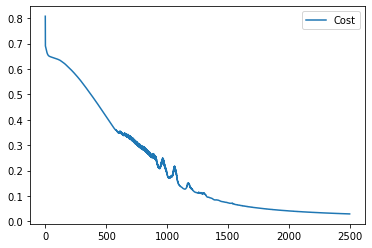

In [6]:
cost_data.plot()

In [7]:
cost_data.tail(5)

,Cost
2495,0.029619
2496,0.029601
2497,0.029580
2498,0.029569
2499,0.029549


In [8]:
preds

array([[9.87882033e-01, 9.95063204e-01, 9.71741009e-01, 9.82799781e-01,
        6.60120897e-01, 9.43789149e-01, 2.26566858e-03, 6.81436254e-01,
        9.94302861e-01, 9.92465190e-01, 9.77560458e-01, 9.97362850e-01,
        9.95305231e-01, 9.86084506e-01, 5.43601838e-04, 9.91242525e-01,
        9.12994049e-03, 9.69284827e-01, 2.93946454e-02, 4.26249550e-03,
        9.89058795e-01, 2.16429245e-02, 1.92433939e-04, 6.61005322e-01,
        9.11041426e-01, 9.65362454e-01, 9.65779916e-01, 6.91477992e-04,
        5.18085847e-02, 9.99999660e-01, 9.44206698e-01, 9.19122258e-01,
        5.87129263e-01, 8.19731252e-01, 8.82872796e-01, 7.91600823e-04,
        7.07192941e-03, 9.94003255e-01, 1.75733569e-01, 4.65804698e-02,
        8.09383119e-01, 7.65367872e-01, 9.53626182e-01, 6.80375016e-03,
        9.87029974e-01, 1.15498749e-01, 1.10523569e-01, 9.98229122e-01,
        8.08601311e-01, 9.77783606e-03]])

In [9]:
test_Y

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

In [10]:
np.sum((1 * (preds >= 0.5)) == test_Y) / test_Y.shape[1]

0.8

In [11]:
preds[-1][-1]

0.009777836061947136

In [12]:
train_X.shape

(12288, 209)

In [13]:
train_Y.shape

(1, 209)